# Прогноз сердечной недостаточности

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, ежегодно унося около 17,9 миллионов жизней, что составляет 31% всех смертей в мире. Сердечная недостаточность - частое явление, вызываемое сердечно-сосудистыми заболеваниями, и этот набор данных содержит 12 функций, которые можно использовать для прогнозирования смертности от сердечной недостаточности. Большинство сердечно-сосудистых заболеваний можно предотвратить путем устранения поведенческих факторов риска, таких как употребление табака, нездоровое питание и ожирение, недостаточная физическая активность и вредное употребление алкоголя, с использованием стратегий, охватывающих все население. Людям с сердечно-сосудистыми заболеваниями или людям с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) необходимо раннее выявление и лечение, при этом модель машинного обучения может оказаться очень полезной.

**Постановка задачи:**

Создать модель для оценки вероятности смерти от сердечной недостаточности. Это может быть использовано для помощи больницам в оценке степени тяжести пациентов с сердечно-сосудистыми заболеваниями.

*Dataset from Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020).*

## Импорты

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)      

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Чтение и предобработка данных

В датасете имеется набор параметров, позволяющих оценить вероятность летального исхода от сердечной недостаточности.

In [ ]:
heart = pd.read_csv('heart_failure_clinical_records_dataset.csv')
heart.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Переменная time обозначает количество дней, которые прошли с момента предыдущего наблюдения.

Проверим типы данных и наличие отсутствующих значений.

In [ ]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Видно, что все данные представлены в числовом формате и не имеют пропусков.

In [ ]:
heart.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Исследуем целевой столбец:

In [ ]:
heart.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Видно, что данные плохо сбалансированны, что будет учтено далее.

Возраст лежит в диапазоне от 40 до 60 лет, показатели анемии, диабета, пола и курения бинарные. Значения лежат в допустимых нормах.

## Разведочный анализ

Нужно посмотреть на графики, выявить тенденции, аномалии и взаимосвязи.

In [ ]:
num_cols = ['creatinine_phosphokinase', 'ejection_fraction','platelets','serum_creatinine','serum_sodium']
cat_cols = ['anaemia', 'diabetes','high_blood_pressure','sex','smoking','age','time']

Ниже приведен график корреляции. Сильные корреляции между признакоми не видны.

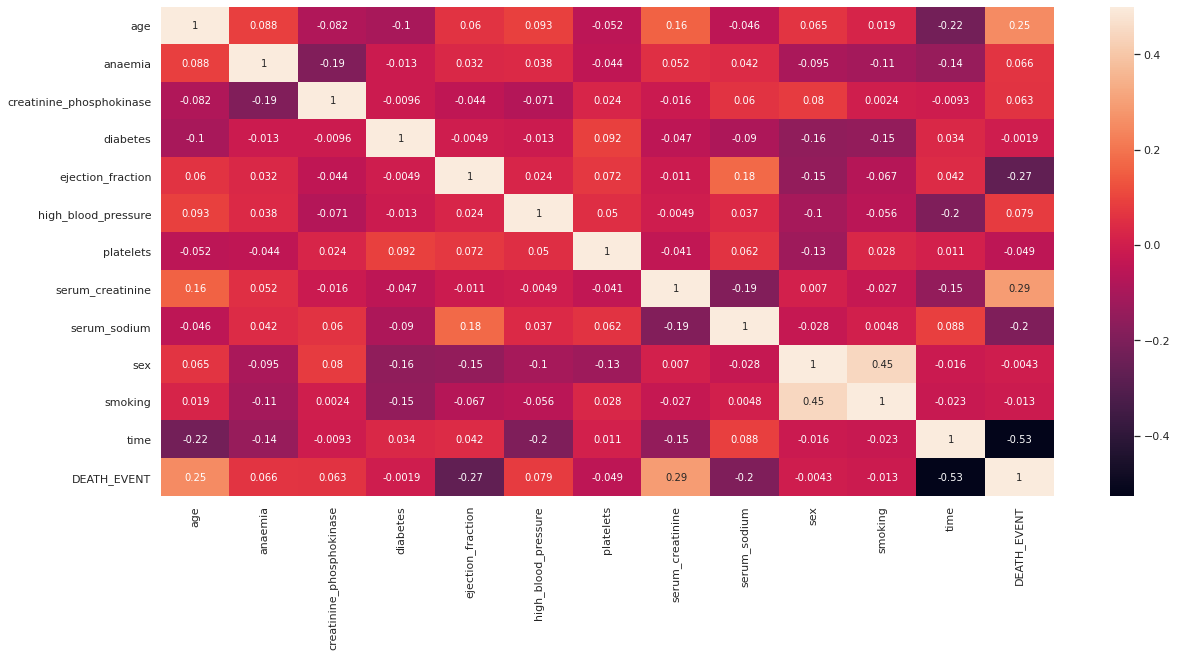

In [ ]:
corrmat = heart.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.5, annot=True);

Посмотримм графики распределения. Четких зависимостей не видно.

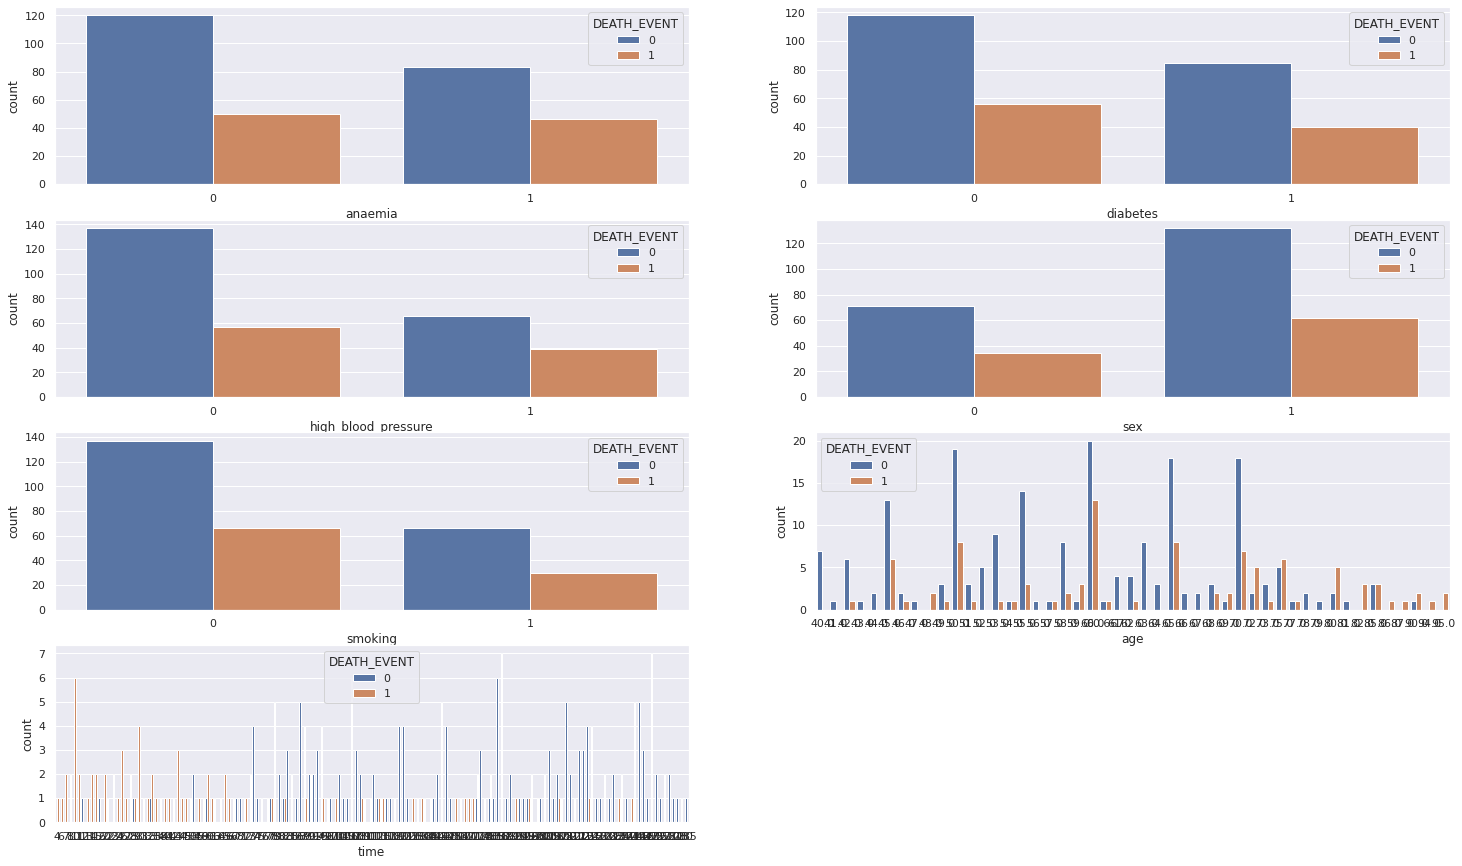

In [ ]:
plt.figure(figsize = (25,15))
for idx,col in enumerate(heart[cat_cols]):
    plt.subplot(4,2,idx+1)
    sns.countplot(x=heart[col], hue=heart.DEATH_EVENT)
None

Посмотрим на распределение числовых признаков и наличие выбросов.


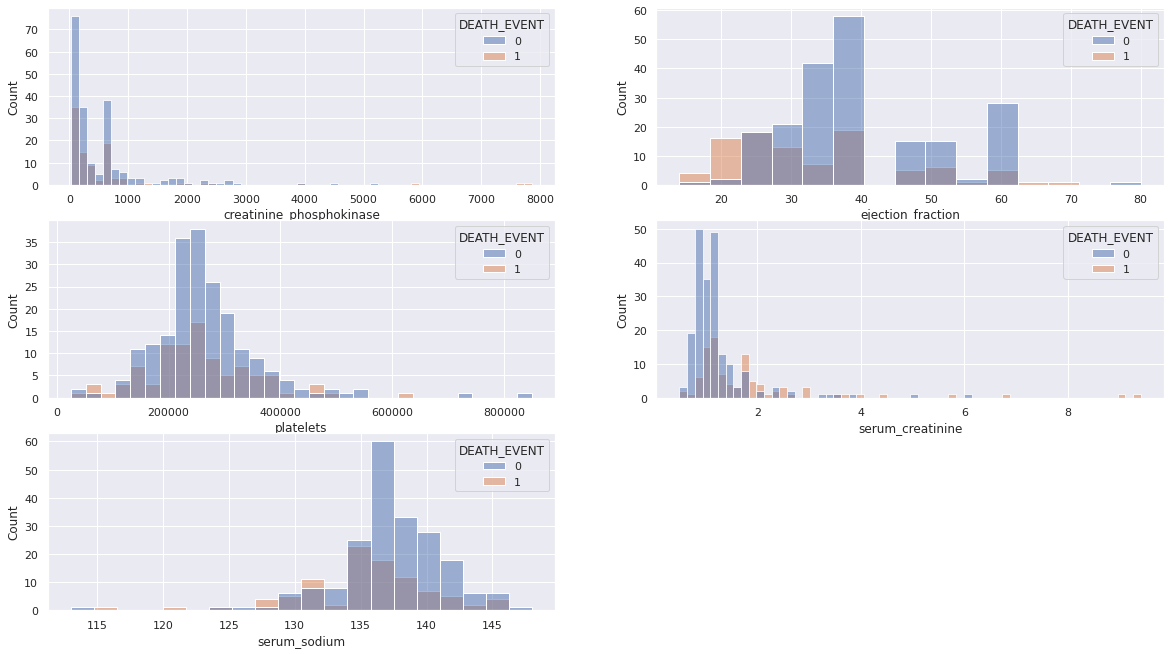

In [ ]:
plt.figure(figsize = (20,15))
for idx,col in enumerate(heart[num_cols]):
    plt.subplot(4,2,idx+1)
    sns.histplot(x=heart[col], hue=heart.DEATH_EVENT)
None

 У столбцов creatinine_phosphokinase, platelets и serum_creatinine сильные хвосты распределения. Я не уверена, могут ли эти переменные принимать такие значения, однако удалять их не буду, так как данных и так слишком мало.

 Для пердварительной обработки буду использовать Robust Scaler.

In [ ]:
#heart = heart[(heart.platelets<600000)&(heart.creatinine_phosphokinase<4000)&(heart.serum_creatinine<5)]
#heart

## Генерация признаков

Попробуем сгенерировать несколько дополнительных признаков.

In [ ]:
heart['bad_health'] = heart.anaemia*heart.diabetes*heart.high_blood_pressure*heart.smoking
heart['old'] = np.where(heart.age>70, 1, 0)
heart['big_time'] = np.where(heart.time>40, 1, 0)

In [ ]:
heart.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,bad_health,old,big_time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,0,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0,0,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0,0,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0,0,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,0,0,0


Подготовим данные для машинного обучения. Разделим выборки на обучающую и валидационную.

In [ ]:
y = heart.DEATH_EVENT
X = heart.drop(['DEATH_EVENT'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify = y)
print(X_train.shape, X_test.shape)

(239, 15) (60, 15)


Признаки имеют разные приделы значений, поэтому масштабируем их.

### Oversampling

Данных слишком мало и выборка не сбалансирована, поэтому к обучающему набору попробуем применить алгоритм SMOTE для добавления новых строк и балансировки.

In [ ]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train.values.ravel())
X_train = pd.DataFrame(X_train_smote, columns=X_train.columns)
y_train = y_train_smote

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train.shape, y_train.shape

((324, 15), (324,))

## Выбор оптимальной модели

Будем использовать несколько моделей, а затем сравним результаты. Для линейных моделей признаки нужно стандартизировать, сделаем это с помощью make pipeline.

Важно, чтобы все люди, которые могут умереть были выявлены, поэтому за основную метрику я приняла полноту (recall).

In [ ]:
lr = make_pipeline(RobustScaler(), LogisticRegression(C=10))
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_recall = recall_score(y_test, lr_pred)
lr_rocauc = roc_auc_score(y_test, lr_pred)

print(f"Результат Логистической регрессии на тестовом наборе: roc auc = {round(lr_rocauc,3)}, recall = {round(lr_recall,3)}")

Результат Логистической регрессии на тестовом наборе: roc auc = 0.69, recall = 0.526


In [ ]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_recall = recall_score(y_test, knn_pred)
knn_rocauc = roc_auc_score(y_test, knn_pred)

print(f"Результат KNN на тестовом наборе: roc auc = {round(knn_rocauc,3)}, recall = {round(knn_recall,3)}")

Результат KNN на тестовом наборе: roc auc = 0.69, recall = 0.526


In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_recall = recall_score(y_test, rf_pred)
rf_rocauc = roc_auc_score(y_test, rf_pred)

print(f"Результат Случайного леса на тестовом наборе: roc auc = {round(rf_rocauc,3)}, recall = {round(rf_recall,3)}")

Результат Случайного леса на тестовом наборе: roc auc = 0.767, recall = 0.632


In [ ]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_recall = recall_score(y_test, xgb_pred)
xgb_rocauc = roc_auc_score(y_test, xgb_pred)

print(f"Результат Градиентного бустинга на тестовом наборе: roc auc = {round(xgb_rocauc,3)}, recall = {round(xgb_recall,3)}")

Результат Градиентного бустинга на тестовом наборе: roc auc = 0.753, recall = 0.579


Отобразим полученные результаты на графике

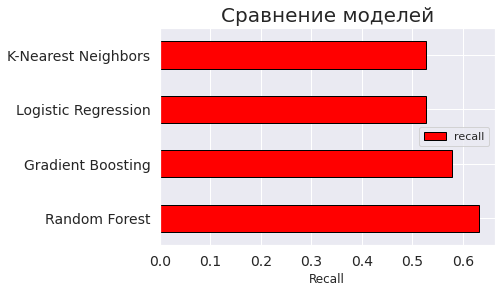

In [ ]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Logistic Regression',
                                           'Random Forest', 'Gradient Boosting',
                                            'K-Nearest Neighbors'],
                                 'recall': [lr_recall, rf_recall,xgb_recall, knn_recall]})


model_comparison.sort_values('recall', ascending = False).plot(x = 'model', y = 'recall', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Recall'); plt.xticks(size = 14)
plt.title('Сравнение моделей', size = 20);

Лучший результат на дефолтных параметрах показывают Случайный лес и Логистическая регрессия.


## Оптимизация гиперпараметров

Попробум настроить параметры моделей. Возьмем логистическую регрессию и случайный лес.

Логистическая регрессия

In [ ]:
logistic = make_pipeline(RobustScaler(), LogisticRegressionCV(refit=True, scoring='recall', random_state=42))
logistic.fit(X_train, y_train)
logistic_pred_train = logistic.predict(X_train)
logistic_pred = logistic.predict(X_test)

print(f"Результат на обучающей выборке: roc_auc = {round(roc_auc_score(y_train,logistic_pred_train),3)}, recall = {round(recall_score(y_train,logistic_pred_train),3)}")
print(f"Результат на тестовой выборке: roc_auc = {round(roc_auc_score(y_test,logistic_pred),3)}, recall = {round(recall_score(y_test,logistic_pred),3)}")

Результат на обучающей выборке: roc_auc = 0.889, recall = 0.883
Результат на тестовой выборке: roc_auc = 0.69, recall = 0.526


Случайный лес

In [ ]:
random_forest = RandomForestClassifier(random_state = 42)

In [ ]:
params = {
        'n_estimators': [50,150,200,300],
        'max_depth': [5,10,20,50],
        'min_samples_split': [1,5,10],
        'min_samples_leaf' : [1, 2],          
        }

In [ ]:
clf = GridSearchCV(random_forest, params, n_jobs=-1, cv=5, scoring='recall', verbose=3, refit=True)

In [ ]:
%%time
clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   52.9s


CPU times: user 2.24 s, sys: 127 ms, total: 2.36 s
Wall time: 1min 31s


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
clf.best_score_

0.9005681818181819

In [ ]:
# Лучшие параметры, которые подобрались с помощью поиска по сетке
clf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [ ]:
best_clf = clf.best_estimator_


In [ ]:
clf_pred_train = best_clf.predict(X_train)
clf_pred = best_clf.predict(X_test)

print(f"Результат на обучающей выборке: roc_auc = {round(roc_auc_score(y_train,clf_pred_train),3)}, recall = {round(recall_score(y_train,clf_pred_train),3)}")
print(f"Результат на тестовой выборке: roc_auc = {round(roc_auc_score(y_test,clf_pred),3)}, recall = {round(recall_score(y_test,clf_pred),3)}")

Результат на обучающей выборке: roc_auc = 0.972, recall = 0.975
Результат на тестовой выборке: roc_auc = 0.741, recall = 0.579


In [ ]:
roc_auc_score(y_test,best_clf.predict_proba(X_test)[:,1])

0.8908857509627728

## Обработка результатов

Исследуем важность признаков.

In [ ]:
importances = best_clf.feature_importances_

feature_list = list(X.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results

,feature,importance
0,big_time,0.234263
1,time,0.205455
2,serum_creatinine,0.147773
3,ejection_fraction,0.121003
4,creatinine_phosphokinase,0.049652
5,serum_sodium,0.047412
6,old,0.046488
7,platelets,0.046397
8,age,0.026847
9,high_blood_pressure,0.024269


## Выводы

В работе использовались модели машинного обучения для оценки вероятности смерти пациента от сердечной недостаточности.

Построено несколько моделей и оценено их качество. 

Логистическая регрессия и случайный лес работают примерно одинаково, хотя даные линейно не разделимы.